# Get distance matrices

We need to get different distance matrices (alpha, beta, and combined).

In [1]:
from tcrdist.repertoire import TCRrep
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import umap

In [2]:
import pandas as pd
df = pd.read_csv('./data/vdjdb.txt', sep="\t")

In [3]:
# Select the columns we need
selected_features = df[['complex.id', 'gene','cdr3','v.segm','j.segm','species','mhc.a','mhc.b','mhc.class','antigen.epitope','antigen.species','vdjdb.score']]

In [4]:
# Select all human data
human_data = selected_features[(selected_features['species'] == 'HomoSapiens') & (selected_features['vdjdb.score'] > 0)]

# Drop duplicate rows
human_data = human_data.drop_duplicates()

# Delete rows with null values
human_data  = human_data.dropna()
# Print all data
human_data.head()

,complex.id,gene,cdr3,v.segm,j.segm,species,mhc.a,mhc.b,mhc.class,antigen.epitope,antigen.species,vdjdb.score
0,1,TRA,CIVRAPGRADMRF,TRAV26-1*01,TRAJ43*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
1,1,TRB,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
2,0,TRB,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
3,2,TRA,CAVPSGAGSYQLTF,TRAV20*01,TRAJ28*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2
4,2,TRB,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,HomoSapiens,HLA-B*08,B2M,MHCI,FLKEKGGL,HIV-1,2


# Get alpha chains

In [5]:
# Do the same as above but for alpha chains

TRA = human_data[human_data['gene'] =='TRA']
alpha_chains = TRA[['cdr3', 'v.segm', 'j.segm','antigen.epitope']]
alpha_chains.rename(columns={'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene','antigen.epitope':'epitope'}, inplace=True)



C:\Users\adnan\AppData\Local\Temp\ipykernel_16228\1048392231.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_chains.rename(columns={'cdr3':'cdr3_a_aa','v.segm':'v_a_gene', 'j.segm':'j_a_gene','antigen.epitope':'epitope'}, inplace=True)


# Get beta chains

In [6]:
# get beta chains only
TRB = human_data[human_data['gene'] =='TRB']
# rename the columns for our beta chain matrix calculation
beta_chains = TRB[['cdr3', 'v.segm', 'j.segm','antigen.epitope']]
beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene','antigen.epitope':'epitope'}, inplace=True)
beta_chains

C:\Users\adnan\AppData\Local\Temp\ipykernel_16228\425838689.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  beta_chains.rename(columns={'cdr3':'cdr3_b_aa','v.segm':'v_b_gene', 'j.segm':'j_b_gene','antigen.epitope':'epitope'}, inplace=True)


,cdr3_b_aa,v_b_gene,j_b_gene,epitope
1,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
2,CASSFEAGQGFFSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
4,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
6,CASSYEPGQVSHYSNQPQHF,TRBV13*01,TRBJ1-5*01,FLKEKGGL
8,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,FLKEKGGL
...,...,...,...,...
92682,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,PQPELPYPQPQL
92684,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,FPQPEQPFPWQP
92686,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,FPQPEQPFPWQP
92690,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,QLQPFPQPELPY


# Get paired alpha and beta pairs

In [30]:
# Let's get all the IDs for the TCRs (A & B pairs should have the same ID)
_ids = human_data['complex.id']
_ids

0            1
1            1
2            0
3            2
4            2
         ...  
92686    30552
92689    30554
92690    30554
92767    30593
92768    30593
Name: complex.id, Length: 7799, dtype: int64

In [31]:
list_to_combine = []
checked_ids = []
def process_row(row):
    # check the complex id not already checked
    if row['complex.id'] not in checked_ids:
        # find matching rows
        matched_rows = human_data[human_data['complex.id'] == row['complex.id']]
        # should be two (some rows have only 1 match)
        if len(matched_rows) == 2:
            # get the tcra row
            tra_row = matched_rows.iloc[0]
            # get the tcrb row
            trb_row = matched_rows.iloc[1]
            # add to list as a combined row
            list_to_combine.append({'tcr_id_a':tra_row['complex.id'], 'tcr_id_b':trb_row['complex.id'], 
                                    'cdr3_a_aa': tra_row['cdr3'], 'cdr3_b_aa': trb_row['cdr3'],
                                    'v_b_gene' :trb_row['v.segm'],
                                    'j_b_gene':trb_row['j.segm'],
                                    'v_a_gene':tra_row['v.segm'],
                                    'j_a_gene':tra_row['j.segm'],
                                    'epitope':tra_row['antigen.epitope'] ,
                                   })
            # we've checked this id now, so we need to make sure we don't have to check it again.
            checked_ids.append(row['complex.id'])
human_data.apply(process_row, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
92686    None
92689    None
92690    None
92767    None
92768    None
Length: 7799, dtype: object

In [53]:
# Create table representing paired tcr rows
paired_chains = pd.DataFrame(list_to_combine)
paired_chains

,tcr_id_a,tcr_id_b,cdr3_a_aa,cdr3_b_aa,v_b_gene,j_b_gene,v_a_gene,j_a_gene,epitope
0,1,1,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV26-1*01,TRAJ43*01,FLKEKGGL
1,2,2,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV20*01,TRAJ28*01,FLKEKGGL
2,4,4,CAYRPPGTYKYIF,CASSALASLNEQFF,TRBV14*01,TRBJ2-1*01,TRAV38-2/DV8*01,TRAJ40*01,FLKEKGGL
3,5,5,CIVRAPGRADMRF,CASSYLPGQGDHYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV26-1*01,TRAJ43*01,FLKEQGGL
4,6,6,CAVPSGAGSYQLTF,CASSFEPGQGFYSNQPQHF,TRBV13*01,TRBJ1-5*01,TRAV20*01,TRAJ28*01,FLKEQGGL
...,...,...,...,...,...,...,...,...,...
1863,30550,30550,CIALNARLMF,CASSLRATDTQYF,TRBV7-2*01,TRBJ2-3*01,TRAV26-1*01,TRAJ31*01,PQPELPYPQPQL
1864,30551,30551,CAMREGRYSSASKIIF,CATSRAGGGGEKLFF,TRBV15*01,TRBJ1-4*01,TRAV14/DV4*01,TRAJ3*01,FPQPEQPFPWQP
1865,30552,30552,CLVGDGDGGATNKLIF,CASSQGSGGNEQFF,TRBV4-3*01,TRBJ2-1*01,TRAV4*01,TRAJ32*01,FPQPEQPFPWQP
1866,30554,30554,CAASVLYGSSNTGKLIF,CASSIVGSGGYNEQFF,TRBV19*01,TRBJ2-1*01,TRAV29/DV5*01,TRAJ37*01,QLQPFPQPELPY


# Testing KNN as benchmark for predictions

In [92]:
chains_to_use = ['alpha','beta'] # specify which chains we want to use
data_to_use = paired_chains # specify the data that represents these chains

def set_up_data(chains_to_use, data_to_use):

    # We only want to use the top 5 antigens with the most tcrs
    value_counts_antigen = data_to_use['epitope'].value_counts()
    top_5_value_counts = value_counts_antigen.nlargest(5)
    matrix_filtered = data_to_use[data_to_use['epitope'].isin(top_5_value_counts.index)]
    data_to_use = matrix_filtered
    
    train_df, test_df = train_test_split(data_to_use, test_size=0.2, random_state=42) # split our data into training/test sets
    train_df.head()
    train_df.rename(columns={'antigen.epitope': 'epitope'}, inplace=True) # we need to rename this column so it matches what is expected.
    number_tcr_originally = train_df.shape[0] # let's figure out how many tcrs we have 
    print(f'Our dataset has {train_df.shape[0]} TCRs for {len(train_df["epitope"].unique())} different epitopes\n') # let's see how manyt epitopes
    # Specify columns we need to drop from.
    cols_to_drop = ['epitope']

    # we need to add alpha chain cdr3_a_aa column if we want to use alpha chains
    if 'alpha' in chains_to_use:
        cols_to_drop += ['cdr3_a_aa']

    # we need to add beta chain cdr3_b_aa column if we want to use beta chains
    if 'beta' in chains_to_use:
        cols_to_drop += ['cdr3_b_aa']
    
    train_df = train_df.drop_duplicates(subset=cols_to_drop, keep='first').copy() # removing duplicates
    train_df.reset_index(drop=True, inplace=True)

    print(f'Removed {number_tcr_originally - train_df.shape[0]} duplicate TCRs by columns {cols_to_drop}.')
    print(f'The new number of TCRs for each epitope:')
    print(train_df['epitope'].value_counts())
    
    return [train_df, test_df]

In [93]:
train_df, test_df = set_up_data(chains_to_use, data_to_use)

Our dataset has 726 TCRs for 5 different epitopes

Removed 191 duplicate TCRs by columns ['epitope', 'cdr3_a_aa', 'cdr3_b_aa'].
The new number of TCRs for each epitope:
NLVPMVATV         239
GILGFVFTL         141
TFEYVSQPFLMDLE     69
GLCTLVAML          43
YLQPRTFLL          43
Name: epitope, dtype: int64


## Get distances for training set

In [101]:
def get_distances_training_set(train_df,chains_to_use):
    
    tr = TCRrep(cell_df=train_df,
                chains = chains_to_use,
                organism='human', 
                deduplicate=True)
    # we need to create different X data frame depending on what chains we want to use..
    if chains_to_use==['alpha']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa) # for alpha chains only
    if chains_to_use==['beta']: 
        X = pd.DataFrame(tr.pw_cdr3_b_aa) # for beta chains only
    if chains_to_use==['alpha', 'beta']:
        X = pd.DataFrame(tr.pw_cdr3_a_aa + tr.pw_cdr3_b_aa) # for combined chains

    Y = pd.DataFrame(tr.clone_df['epitope']) # training labels for our tcrs

    # let's project data using UMAP
    training_reduced_embeddings = umap.UMAP(n_components = 2, n_neighbors = 2, metric='hellinger').fit_transform(X)
    train_reduced_df = pd.DataFrame(training_reduced_embeddings)
    train_reduced_df.columns = train_reduced_df.columns.astype(str)
    
    return [train_reduced_df,Y]

In [102]:
train_reduced_df, Y = get_distances_training_set(train_df,chains_to_use)

,epitope
0,GILGFVFTL
1,GILGFVFTL
2,NLVPMVATV
3,NLVPMVATV
4,GILGFVFTL
...,...
530,YLQPRTFLL
531,YLQPRTFLL
532,YLQPRTFLL
533,YLQPRTFLL


## Train our model

In [107]:
def train_model(train_reduced_df,Y):
    ## Train knn model
    # we train the model on our whole train set
    knn = KNeighborsClassifier()

    # We use grid search for cross validation to get the best K.
    param_grid = {'n_neighbors': range(2, 100)} 

    # Perform grid search using cross-validation
    grid_search = GridSearchCV(knn, param_grid, cv=10)  #  Let's use 5 fold.

    # We fit to our training data
    grid_search.fit(train_reduced_df, Y.values.ravel())

    # set the model to be the best performing one.
    model = grid_search.best_estimator_
    
    return model

model = train_model(train_reduced_df,Y)

In [108]:
print('Our test set has {} TCRs'.format(test_df.shape[0]))

Our test set has 182 TCRs


In [109]:
# change column name
test_df.rename(columns={'antigen.epitope': 'epitope'}, inplace=True)

In [110]:
# For confusion matrix. We only keep the epitopes that are also available in the train set
list_of_epitopes = list(train_df['epitope'].unique())
test_df = test_df.loc[test_df['epitope'].isin(list_of_epitopes)]
test_df.reset_index(drop=True, inplace=True)

# Get distances matrix (call it X_test) between test and train TCRs

In [111]:
def get_test_distances_predictions(test_df,chains_to_use):
    test_tcrs = TCRrep(cell_df=test_df,
                         organism='human', 
                         chains=chains_to_use,
                         deduplicate=True)

    test_tcrs.compute_rect_distances(df=test_tcrs.clone_df, 
                                        df2=tr.clone_df)
    if chains_to_use==['alpha']:
        X_test = pd.DataFrame(test_tcrs.rw_cdr3_a_aa)
    if chains_to_use==['beta']:
        X_test = pd.DataFrame(test_tcrs.rw_cdr3_b_aa)
    if chains_to_use ==['alpha', 'beta']:
        X_test = pd.DataFrame(test_tcrs.rw_cdr3_a_aa + test_tcrs.rw_cdr3_b_aa)

    test_reduced_embeddings = umap.UMAP(n_components = 2, n_neighbors = 2).fit_transform(X_test)
    test_reduced_df = pd.DataFrame(test_reduced_embeddings)
    test_reduced_df.columns = test_reduced_df.columns.astype(str)
    X_test = test_reduced_embeddings
    # get predictions
    prediction_labels = model.predict(X_test)

    # Let's fetch test labels
    Y_test = test_tcrs.clone_df['epitope']
    return [Y_test, prediction_labels]

Y_test, prediction_labels = get_test_distances_predictions(test_df,chains_to_use)

C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:159: UserWarning: cell_df needs a counts column to track clonal number of frequency

  self._validate_cell_df()
C:\Users\adnan\anaconda3\lib\site-packages\tcrdist\repertoire.py:791: UserWarning: No 'count' column provided; count column set to 1
  warnings.warn("No 'count' column provided; count column set to 1")
C:\Users\adnan\anaconda3\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
C:\Users\adnan\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


# Getting performance metrics

In [112]:
def get_performance_metrics(Y_test,prediction_labels):
    metrics_holder = {}
    metrics_holder['accuracy'] = accuracy_score(Y_test, prediction_labels)
    metrics_holder['actual_vs_labeled_matrix'] = pd.DataFrame(confusion_matrix(Y_test, prediction_labels), columns=model.classes_, index=model.classes_)
    metrics_table_df = pd.DataFrame(columns=model.classes_)
    metrics_table_df.loc['f1'] = f1_score(Y_test, prediction_labels, average=None)
    metrics_table_df.loc['precision'] = precision_score(Y_test, prediction_labels, average=None)
    metrics_table_df.loc['recall'] = recall_score(Y_test, prediction_labels, average=None)
    return [metrics_holder,metrics_table_df]

metrics_holder,metrics_table_df = get_performance_metrics(Y_test,prediction_labels)

# Plot confusion matrices

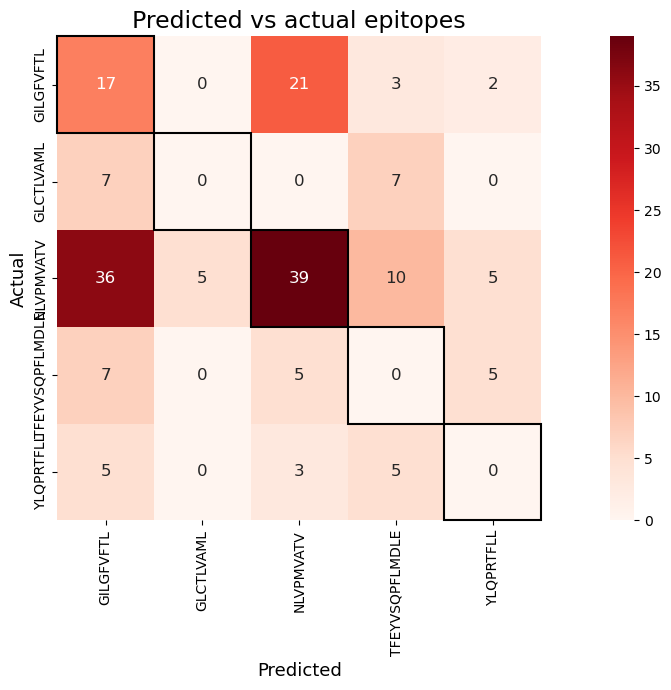

In [113]:
def plot_confusion_matrix(metrics_holder):
    figure, axis = plt.subplots(nrows=1,figsize=(14,7))
    sns.heatmap(metrics_holder['actual_vs_labeled_matrix'], annot=True, cmap='Reds', fmt='', square=True, annot_kws={"size": 12})
    axis.set_xlabel('Predicted', fontsize=13)
    axis.set_ylabel('Actual', fontsize=13)
    axis.set_title('Predicted vs actual epitopes', fontsize=17)
    for tick in axis.get_xticklabels():
            tick.set_rotation(90)


    #Adding boxes to highlight when actual was same as predicted.
    for epitopes in range(metrics_holder['actual_vs_labeled_matrix'].shape[0]):
        axis.add_patch(Rectangle((epitopes, epitopes), 1, 1, ec='black', fc='none', lw=1.5, clip_on=False))
    plt.tight_layout()

plot_confusion_matrix(metrics_holder)

# Plot of metrics for each epitope

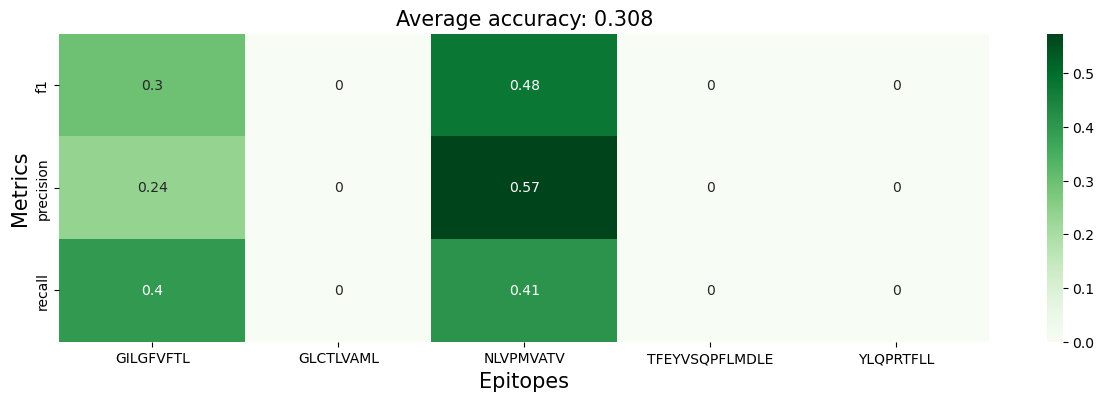

In [115]:
def plot_metrics_for_each_epitope(metrics_table_df,metrics_holder):
    plt.figure(figsize=(15,4))
    axis = sns.heatmap(metrics_table_df, annot=True, cmap='Greens' )
    axis.set_ylabel('Metrics', fontsize=15)
    axis.set_xlabel('Epitopes', fontsize=15)
    axis.set_title(f"Average accuracy: {metrics_holder['accuracy']:.3f}", fontsize=15)
plot_metrics_for_each_epitope(metrics_table_df,metrics_holder)